In [1]:
import sys
sys.path.insert(0, "../../../")

In [2]:
import deeplay as dl
import deeptrack as dt


import numpy as np
import torchvision
import torch

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either cha

In [3]:
train_dataset = dt.Dataset("segmentation_sstem_drosophila", split="train[:80%]")
test_dataset = dt.Dataset("segmentation_sstem_drosophila", split="train[80%:]")

1.0.0
1.0.1
Using ~\tensorflow_datasets\segmentation_sstem_drosophila\1.0.2 instead.
1.0.0
1.0.1
Using ~\tensorflow_datasets\segmentation_sstem_drosophila\1.0.2 instead.
1.0.0
1.0.1
Using ~\tensorflow_datasets\segmentation_sstem_drosophila\1.0.2 instead.
1.0.0
1.0.1
Using ~\tensorflow_datasets\segmentation_sstem_drosophila\1.0.2 instead.


train_dataset images:  16
test_dataset images:  4
image shape:  (1024, 1024, 1)
masks shape:  (1024, 1024, 1)
masks unique values:  Image(array([  0,  32,  64,  96, 128, 159, 191, 223, 255], dtype=uint8))


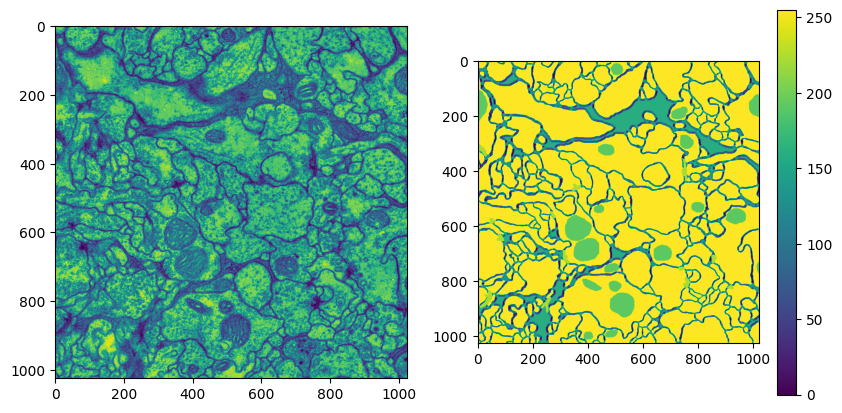

In [4]:
import matplotlib.pyplot as plt
print("train_dataset images: ", train_dataset.size)
print("test_dataset images: ", test_dataset.size)

image, masks = train_dataset.update()()

print("image shape: ", image.shape)
print("masks shape: ", masks.shape)
print("masks unique values: ", np.unique(masks))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(masks)
plt.colorbar()
plt.show()

image shape:  (572, 572, 1)
masks shape:  (572, 572, 1)


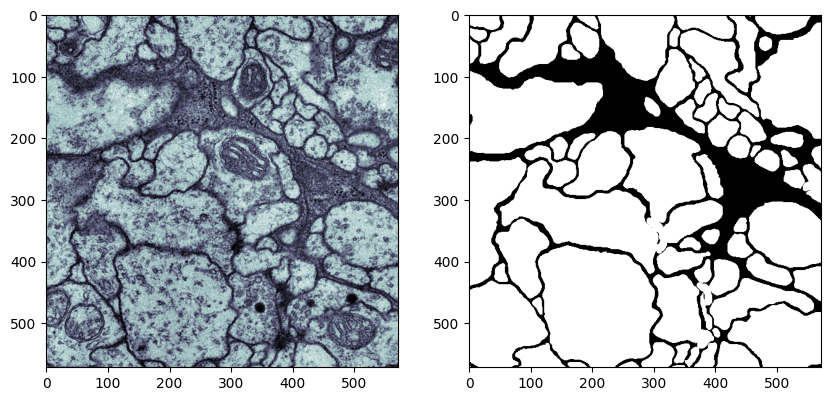

In [18]:
image_processing = dt.Divide(255)
mask_processing = dt.GreaterThan(159)

augmentations = dt.Crop(crop=(572, 572, 1))

train_image_pipeline = train_dataset.image >> image_processing
train_mask_pipeline = train_dataset.label >> mask_processing
train_pipeline = (train_image_pipeline & train_mask_pipeline) >> augmentations 

test_image_pipeline = test_dataset.image >> image_processing
test_mask_pipeline = test_dataset.label >> mask_processing
test_pipeline = test_image_pipeline & test_mask_pipeline

image, masks = train_pipeline.update()()

print("image shape: ", image.shape)
print("masks shape: ", masks.shape)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="bone")
plt.subplot(1, 2, 2)
plt.imshow(masks, cmap="Greys_r")
plt.show()

In [19]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor
import copy
import random


class DynamicDeeptrackDataset(Dataset):
    def __init__(self, data_pipeline: dt.Feature, dataset_size: int, replace_probability=1) -> None:

        self.data_pipeline = data_pipeline
        self.replace_probability = replace_probability  # probability of replacing an image

        # peak image size
        _image, _label = data_pipeline.update().resolve()

        _image_as_tensor = to_tensor(np.array(_image)).float().to("cpu")
        _label_as_tensor = to_tensor(np.array(_label)).float().to("cpu")

        self.dataset = torch.empty(
            (dataset_size, *_image_as_tensor.shape), dtype=torch.float32
        )
        self.labels = torch.empty(
            (dataset_size, *_label_as_tensor.shape), dtype=torch.float32
        )

        self._has_set_once = np.zeros(dataset_size, dtype=bool)

    def __getitem__(self, index):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:
            self._maybe_replace_index(self.data_pipeline, index)

        else:
            self._maybe_replace_index(copy.deepcopy(self.data_pipeline), index)

        return self.dataset[index], self.labels[index]

    def __len__(self):
        return len(self.dataset)

    def _maybe_replace_index(self, pipeline, index):

        if self._has_set_once[index] and random.random() > self.replace_probability:
            return
            
        data, label = self.data_pipeline.update().resolve()
        tensor_data = to_tensor(np.array(data)).float().to("cpu")

        self._has_set_once[index] = True
        self.dataset[index] = tensor_data
        self.labels[index] = to_tensor(np.array(label)).float().to("cpu")

In [20]:
train_torch_dataset = DynamicDeeptrackDataset(train_pipeline, 256, 0.5)
test_torch_dataset = DynamicDeeptrackDataset(test_pipeline, test_dataset.size)

train_torch_dataloader = DataLoader(train_torch_dataset, batch_size=4, shuffle=True)
test_torch_dataloader = DataLoader(test_torch_dataset, batch_size=2, shuffle=False)

In [21]:
sample_image, sample_label = train_torch_dataset[0]

In [22]:
segmentor = dl.ImageSegmentor(
    backbone = dl.UNet(),
)
y = segmentor(sample_image.unsqueeze(0), pad_output=False)
print("Input shape: ", sample_image.shape, "Output shape: ", y.shape)
segmentor

Input shape:  torch.Size([1, 572, 572]) Output shape:  torch.Size([1, 1, 388, 388])


ImageSegmentor(
  (backbone): UNet(
    (input): Template(
      (layer): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
      (activation): ReLU()
      (layer(0)): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (activation(0)): ReLU()
    )
    (encoder_blocks): ModuleList(
      (0): Template(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (LayerSequence): Template(
          (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
          (activation): ReLU()
          (layer(0)): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
          (activation(0)): ReLU()
        )
      )
      (1): Template(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (LayerSequence): Template(
          (layer): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
          (activation): ReLU()
          (layer(0)): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
          (acti

In [23]:
import pytorch_lightning as pl

trainer = pl.Trainer(max_epochs=20, accelerator="cuda", devices=1, log_every_n_steps=1)
trainer.fit(segmentor, train_torch_dataloader, test_torch_dataloader)
trainer.test(segmentor, test_torch_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                  | Params
---------------------------------------------------
0 | backbone | UNet                  | 31.4 M
1 | head     | ImageSegmentationHead | 65    
2 | loss     | BCELoss               | 0     
---------------------------------------------------
31.4 M    Trainable params
0         Non-trainable params
31.4 M    Total params
125.511   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.16989362239837646    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.16989362239837646}]

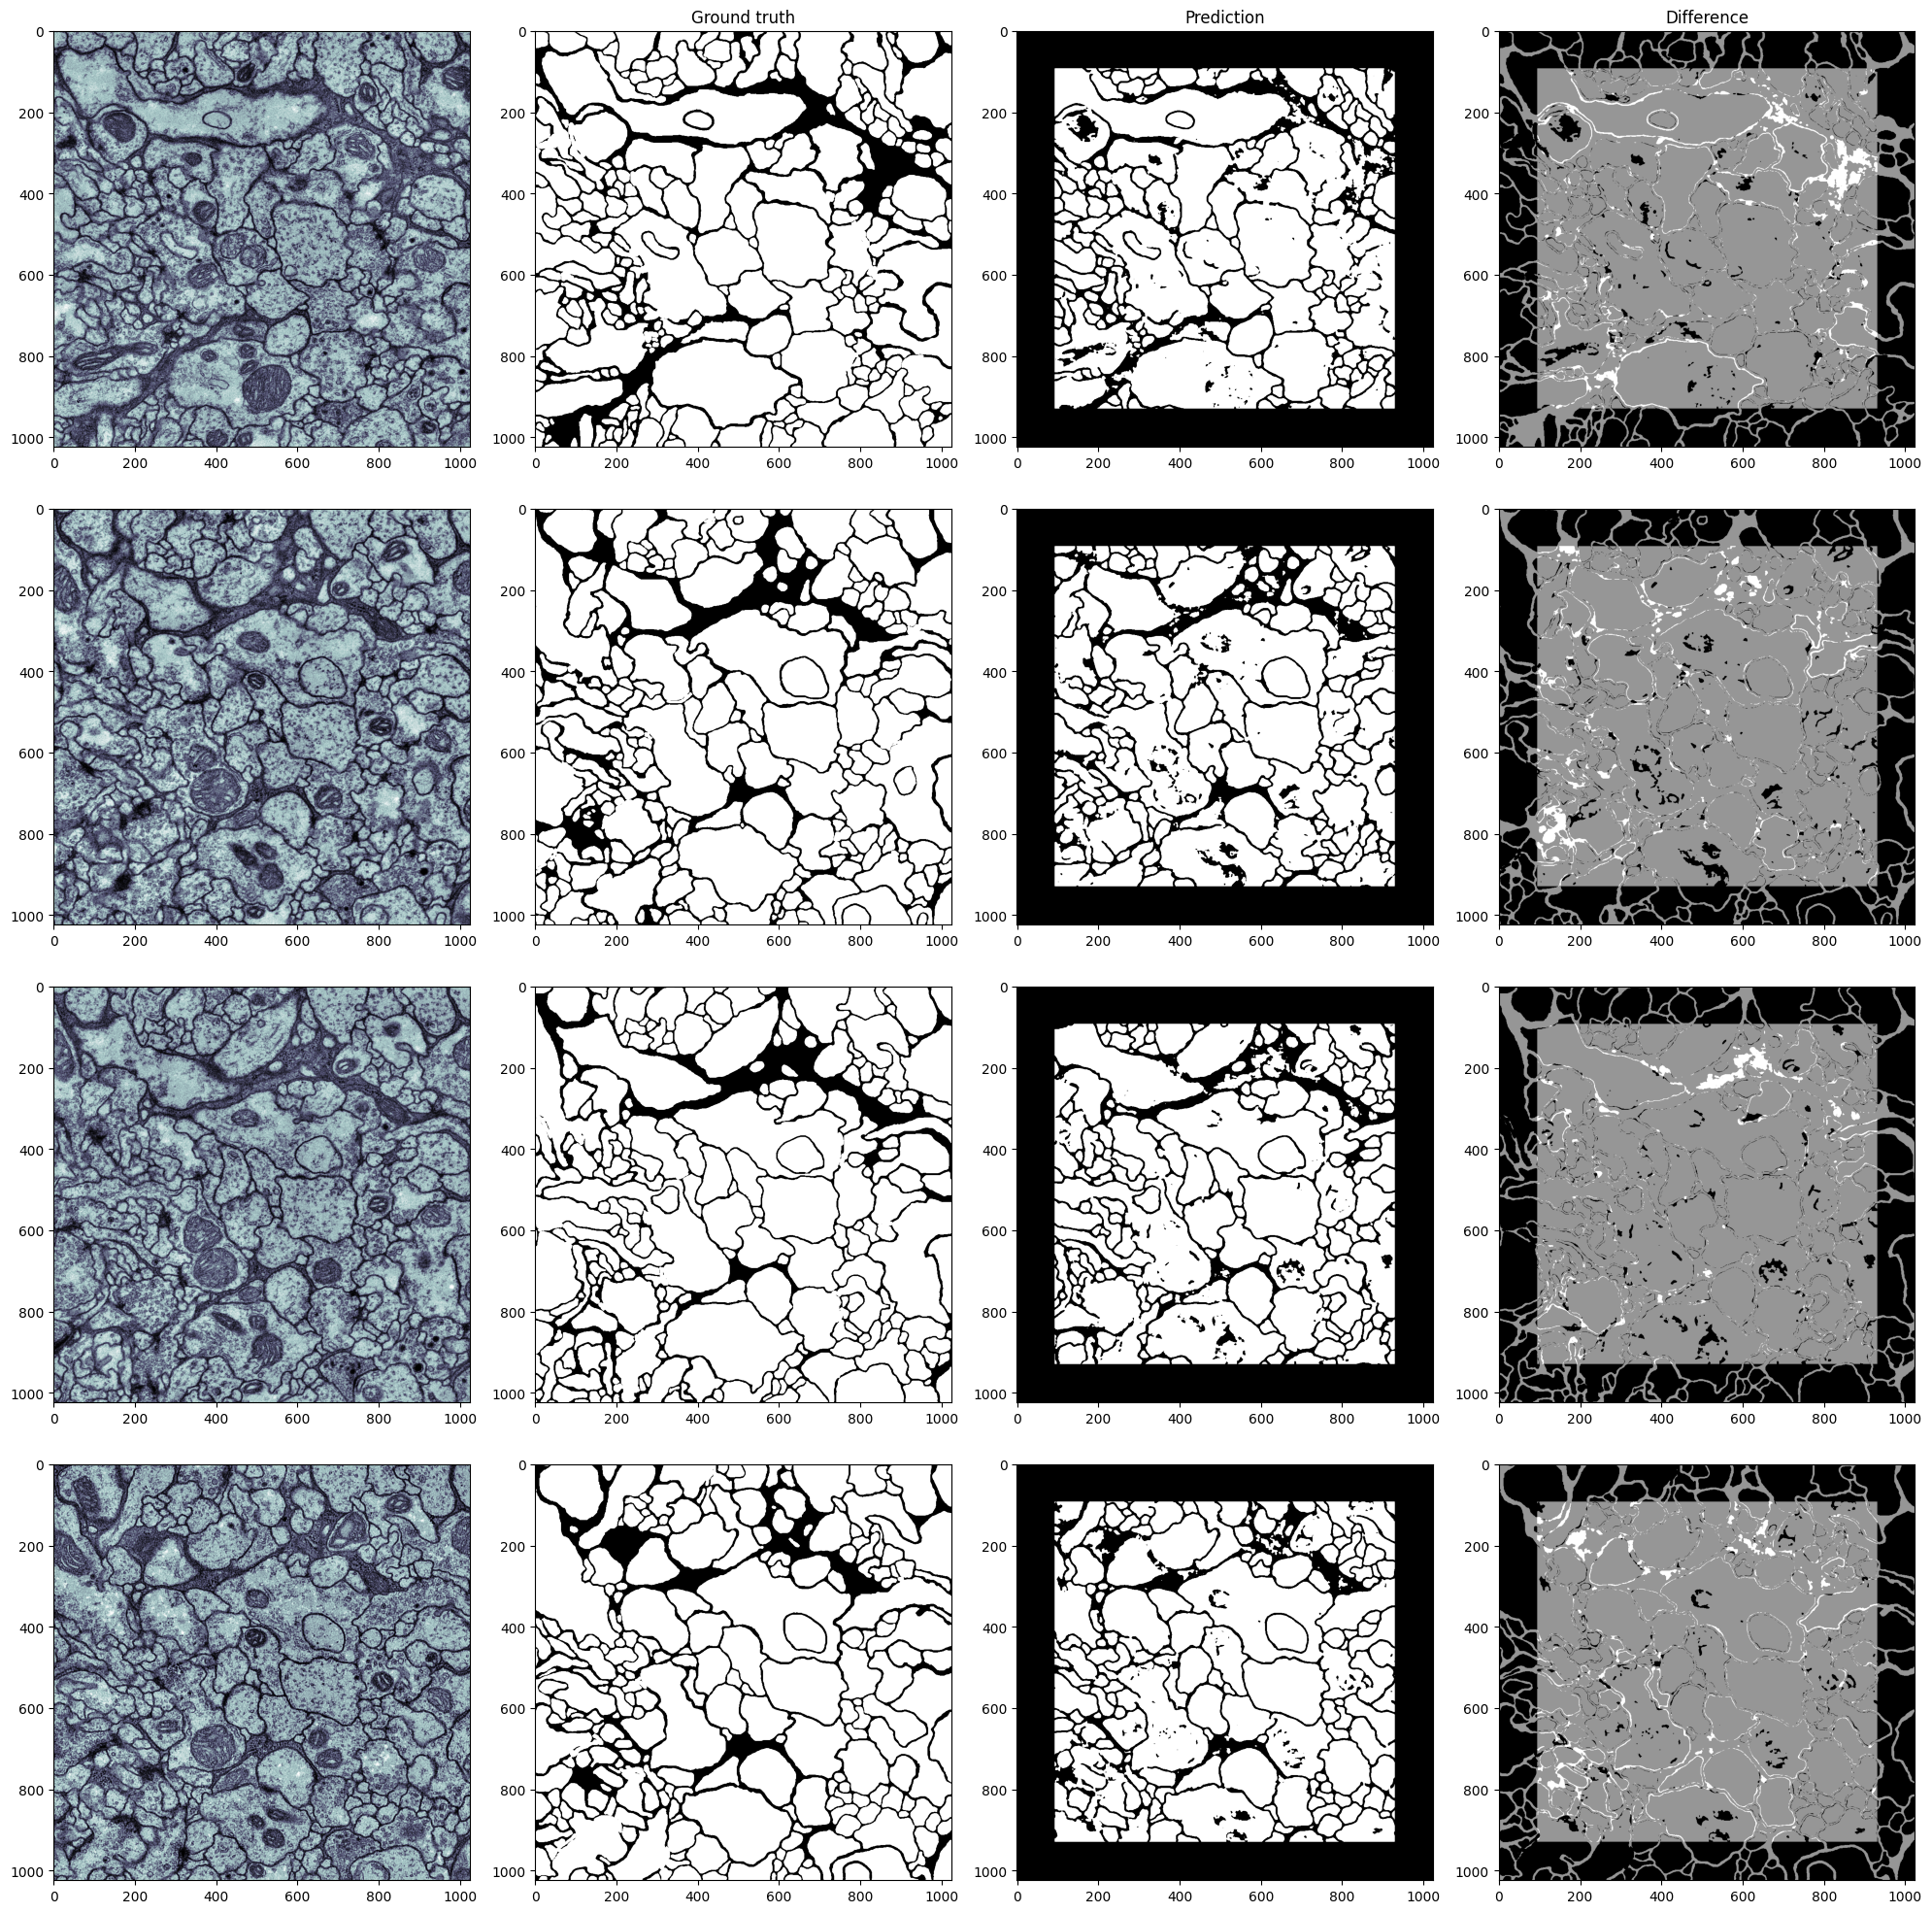

In [24]:
def plot_all_examples(segmentor, test_torch_dataset, n_examples=4):
    plt.figure(figsize=(20, n_examples * 5))

    for idx, (image, mask) in enumerate(test_torch_dataset):
        semgentation = segmentor.segment(image.unsqueeze(0))

        
        plt.subplot(n_examples, 4, 1 + idx * 4)
        plt.imshow(image[0], cmap="bone")
        plt.subplot(n_examples, 4, 2 + idx * 4)
        plt.imshow(mask[0], cmap="Greys_r", vmin=0, vmax=1)
        if idx == 0:
            plt.title("Ground truth")
        plt.subplot(n_examples, 4, 3 + idx * 4)
        plt.imshow(semgentation[0, 0], cmap="Greys_r", vmin=0, vmax=1)
        if idx == 0:
            plt.title("Prediction")
        plt.subplot(n_examples, 4, 4 + idx * 4)
        plt.imshow(semgentation[0, 0] * 1.0 - mask[0] * 1.0, cmap="Greys_r", vmin=-1, vmax=1)
        if idx == 0:
            plt.title("Difference")

    plt.tight_layout()
plot_all_examples(segmentor, test_torch_dataset, n_examples=test_dataset.size)